In [1]:
using ReinforcementLearningAnIntroduction

┌ Info: Precompiling ReinforcementLearningAnIntroduction [02c1da58-b9a1-11e8-0212-f9611b8fe936]
└ @ Base loading.jl:1260
┌ Info: Skipping precompilation since __precompile__(false). Importing ReinforcementLearningAnIntroduction [02c1da58-b9a1-11e8-0212-f9611b8fe936].
└ @ Base loading.jl:1033
┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative /home/tj/.julia/packages/CUDAnative/hfulr/src/CUDAnative.jl:114


In [2]:
using Plots

In [3]:
env = BairdCounterEnv()

BairdCounterEnv(3)

In [4]:
Base.@kwdef struct RecordWeights <: AbstractHook
    weights::Vector{Vector{Float64}}=[]
end

(h::RecordWeights)(::PostActStage, agent, env, obs) = push!(h.weights, agent.policy.π_target.learner.approximator.weights |> deepcopy)

In [5]:
Base.@kwdef struct StateMapping <: AbstractPreprocessor
    mapping::Array{Int,2}=features
end

(p::StateMapping)(s::Int) = @view(p.mapping[s, :])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


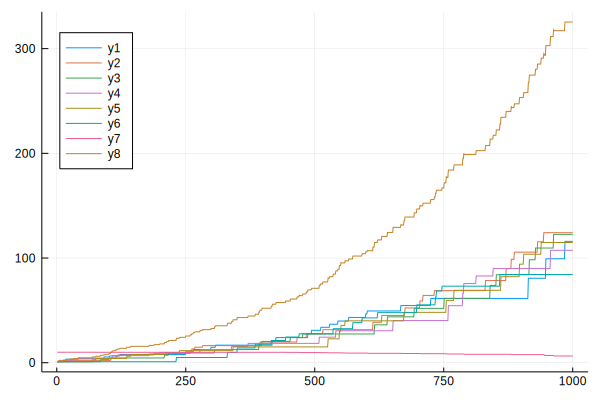

In [7]:
env = BairdCounterEnv()
ns = length(get_observation_space(env))
na = length(get_action_space(env))
init_weights = ones(Float64, 8)
init_weights[7] = 10

features = zeros(ns, length(init_weights))
for i in 1:6
    features[i, i] = 2
    features[i, 8] = 1
end
features[7, 7] = 1
features[7, 8] = 2

π_b = obs -> rand() < 6/7 ? 1 : 2
π_t = VBasedPolicy(
            learner=TDLearner(
                approximator=LinearVApproximator(init_weights),
                γ=0.99,
                optimizer=Descent(0.01),
                n=0,
                method=:SRS
            ),
            mapping = (obs, V) -> [0, 1]
        )
prob_b = [6/7, 1/7]
prob_t = [0., 1.]
RLBase.get_prob(f::typeof(π_b), s, a::Integer) = prob_b[a]
RLBase.get_prob(f::typeof(π_t), s, a::Integer) = prob_t[a]

agent = Agent(
    policy=OffPolicy(
        π_target=π_t,
        π_behavior=π_b
    ),
    trajectory=EpisodicCompactSARTSATrajectory(state_type=Any)
)

env = WrappedEnv(
    env=BairdCounterEnv(),
    preprocessor=StateMapping()
)
hook = RecordWeights()
run(agent, env, StopAfterStep(1000),hook)

p = plot(legend=:topleft)
for i in 1:length(init_weights)
    plot!(p, [w[i] for w in hook.weights])
end
p